## GRU应力应变曲线

### GRUmaxwell 训练，交变协议绘图

In [1]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [2]:
current_directory = os.getcwd()
print(current_directory)

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/home/redfu/work/Constitutive_Equation/stress_strain_fitting
Using GPU: NVIDIA GeForce RTX 2080 Ti


In [3]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = 'data/sin_maxwell_protocols_data.xlsx'

df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
data_special=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    #去除 sheet_data 中的零值
    sheet_data = sheet_data[(sheet_data != 0).all(axis=1)]
    if i==3:
        data_valid=sheet_data
    elif i!=5 :
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)
    else:
        data_special=sheet_data   

df_hf = pd.concat([data_train, data_valid], ignore_index=True)

x1_d_HF = torch.tensor(data_train['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_train['Time'].values, dtype=torch.float32).view(-1, 1)
x3_d_HF = torch.tensor(data_train['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_train['Stress'].values, dtype=torch.float32).view(-1, 1)
# 计算边界

x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
x3min, x3max = torch.min(x3_d_HF), torch.max(x3_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)

lb = torch.tensor([x1min, x2min,x3min ,y1min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, x2max,x3max,y1max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    if lb==ub:
        return vectors
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
x3_d_HF = norm(x3_d_HF, lb[2], ub[2])
y1_d_HF = norm(y1_d_HF, lb[3], ub[3])
# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF,x3_d_HF], dim=1)

y_data_HF= torch.cat([y1_d_HF], dim=1) # 默认训练储存模量

Xy_data_HF = torch.cat([X_data_HF,y_data_HF], dim=1)

# 定义模型
in_dim, out_dim = 3, 1

### 通过滑动窗口构建序列数据

In [4]:
# 定义时间步长
time_steps = 10
# 动态窗口实现
def create_dynamic_window(data, time_steps):
    """
    通过动态窗口将数据调整为适合 LSTM 输入的格式。
    :param data: 输入数据，形状为 (num_samples, ...)
    :param time_steps: 时间步长
    :return: 调整后的数据，形状为 (num_samples - time_steps + 1, time_steps, ...)
    """
    num_samples = data.shape[0]
    if num_samples < time_steps:
        raise ValueError("样本数量必须大于等于时间步长")
    
    # 创建动态窗口
    windowed_data = []
    for i in range(num_samples - time_steps+1):
        window = data[i:i + time_steps]
        windowed_data.append(window)
    
    return torch.stack(windowed_data)

# 调整 X_data_HF
X_data_HF = create_dynamic_window(X_data_HF, time_steps)

# 调整 y_data_HF
# 注意：y_data_HF 通常是目标值，只需要取最后一个时间步的值
y_data_HF = y_data_HF[time_steps-1:]
print(X_data_HF.shape)
print(y_data_HF.shape)

torch.Size([7986, 10, 3])
torch.Size([7986, 1])


In [5]:
x1_d_valid = torch.tensor(data_valid['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_valid = torch.tensor(data_valid['Time'].values, dtype=torch.float32).view(-1, 1)
x3_d_valid = torch.tensor(data_valid['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
y1_d_valid = torch.tensor(data_valid['Stress'].values, dtype=torch.float32).view(-1, 1)

x1_d_valid = norm(x1_d_valid, lb[0], ub[0])
x2_d_valid = norm(x2_d_valid, lb[1], ub[1])
x3_d_valid = norm(x3_d_valid, lb[2], ub[2])
y1_d_valid = norm(y1_d_valid, lb[3], ub[3])

# 合并数据
X_data_valid = torch.cat([x1_d_valid, x2_d_valid,x3_d_valid], dim=1)
y_data_valid= torch.cat([y1_d_valid], dim=1)

In [6]:
# 调整 X_data_valid
X_data_valid = create_dynamic_window(X_data_valid, time_steps)
# 调整 y_data_HF
# 注意：y_data_HF 通常是目标值，只需要取最后一个时间步的值
y_data_valid = y_data_valid[time_steps-1:]

In [7]:
class GRU_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using GRU."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # GRU 隐藏层的维度
                 num_layers=4,    # GRU 层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(GRU_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # 添加 GRU 层
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)
        
        # 添加第一层全连接层（从 GRU 的隐藏状态映射到中间层）
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # 中间层的维度可以与 hidden_size 相同
        
        # 添加第二层全连接层（从中间层映射到输出维度）
        self.out = nn.Linear(hidden_size, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
        # GRU 输入形状: (batch_size, seq_len, input_dim)
        # GRU 输出形状: (batch_size, seq_len, hidden_size)
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        
        # 通过 GRU 层
        gru_out, _ = self.gru(X, h0)
        
        # 取最后一个时间步的输出
        last_time_step = gru_out[:, -1, :]  # (batch_size, hidden_size)
        
        # 通过第一层全连接层
        Z = self.fc1(last_time_step)
        
        # 应用激活函数（如果需要）
        if self.activation is not None:
            Z = self.activation(Z)
        
        # 通过第二层全连接层
        Z = self.out(Z)
        
        return Z

In [8]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model):
        self.model = model # 
        # Initialize history of losses and global iteration counter
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid = self.model(X_data_valid)    
    
        y_pred_HF = self.model(X_data_HF)

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model.parameters())
       # 计算高频数据集的 Huber Loss
        Loss_data_HF = F.smooth_l1_loss(y_pred_HF, y_data_HF) + Loss_L2
        # 计算 dsigma/dt
        # 使用有限差分法计算应力对时间的导数
        dsigma_dt = (y_pred_HF[1:,0] - y_pred_HF[:-1,0]) / 0.01
        # 计算残差
        residual = torch.mean((dsigma_dt + 10 * y_pred_HF[1:, 0] - X_data_HF[1:, -1, 1])**2)
        # 计算验证集的 Huber Loss
        Loss_data_valid = F.smooth_l1_loss(y_pred_valid, y_data_valid) + Loss_L2
        return Loss_data_HF,Loss_data_valid
    
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer, data, scheduler, batch_size, N=1001):
        """This method performs a gradient descent type optimization."""
        # 解包数据
        X_data_HF, y_data_HF, X_data_valid, y_data_valid = data

        # 创建训练数据集和 DataLoader
        train_dataset = TensorDataset(X_data_HF, y_data_HF)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        for i in range(N):
            # 初始化 epoch 的总损失
            epoch_loss_sum = 0.0
            num_batches = 0
            # 遍历每个批次
            for X_batch, y_batch in train_loader:
                # 梯度清0
                optimizer.zero_grad()
                # 计算 loss
                loss, _ = self.loss_fn(X_batch, y_batch, X_data_valid, y_data_valid)

                # 反向传播计算梯度
                loss.backward()

                # 反向传播更新权重和偏置
                optimizer.step()

                # 累加每个批次的损失
                epoch_loss_sum += loss.item()
                num_batches += 1

            # 计算 epoch 的平均损失
            # 在整个验证集上计算验证损失
            loss_train, loss_valid = self.loss_fn(X_data_HF, y_data_HF, X_data_valid, y_data_valid)

            # 记录 epoch 的平均损失
            self.current_loss = loss_train.item()
            self.valid_loss = loss_valid.item()
            # 根据 epoch 的平均损失调度学习率
            scheduler.step(loss_train)
            
            # 计算相对误差
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error, N)  # 将 max_relative_error 传递给回调函数
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3:  # 以 % 为单位
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                                                                    self.current_loss,
                                                                                                    np.round(self.max_relative_error, 3)))
                break
    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 100 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [9]:
model= GRU_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_layers=4,
                             hidden_size=15,
                             activation='relu')

# 初始化 PINNSolver
solver = PINNSolver(model)
model = model.to(device)  # 将模型移动到 GPU
X_data_HF,y_data_HF,X_data_valid,y_data_valid
# 假设 X_data_HF, y_data_HF, X_data_valid, y_data_valid 是 PyTorch 张量
X_data_HF = X_data_HF.to(device)  # 将训练集输入数据移动到 GPU
y_data_HF = y_data_HF.to(device)  # 将训练集标签数据移动到 GPU

X_data_valid = X_data_valid.to(device)  # 将验证集输入数据移动到 GPU
y_data_valid = y_data_valid.to(device)  # 将验证集标签数据移动到 GPU

In [ ]:
# 定义学习率调度器
lr = 1e-4
optimizer = optim.Adam(list(model.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
batch=2000
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(20000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_data_valid,y_data_valid],scheduler,batch,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

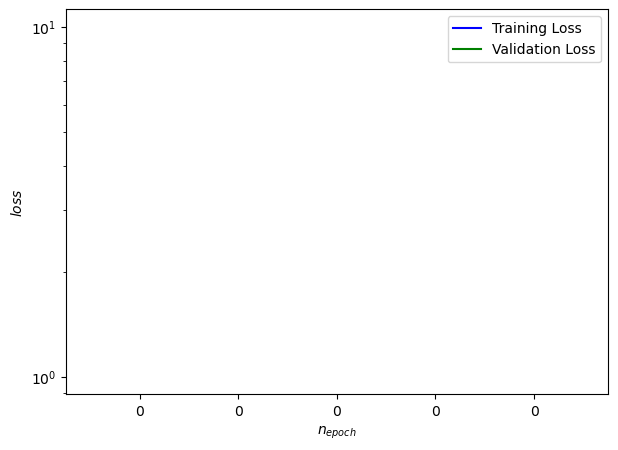

In [10]:
solver.plot_loss_history()

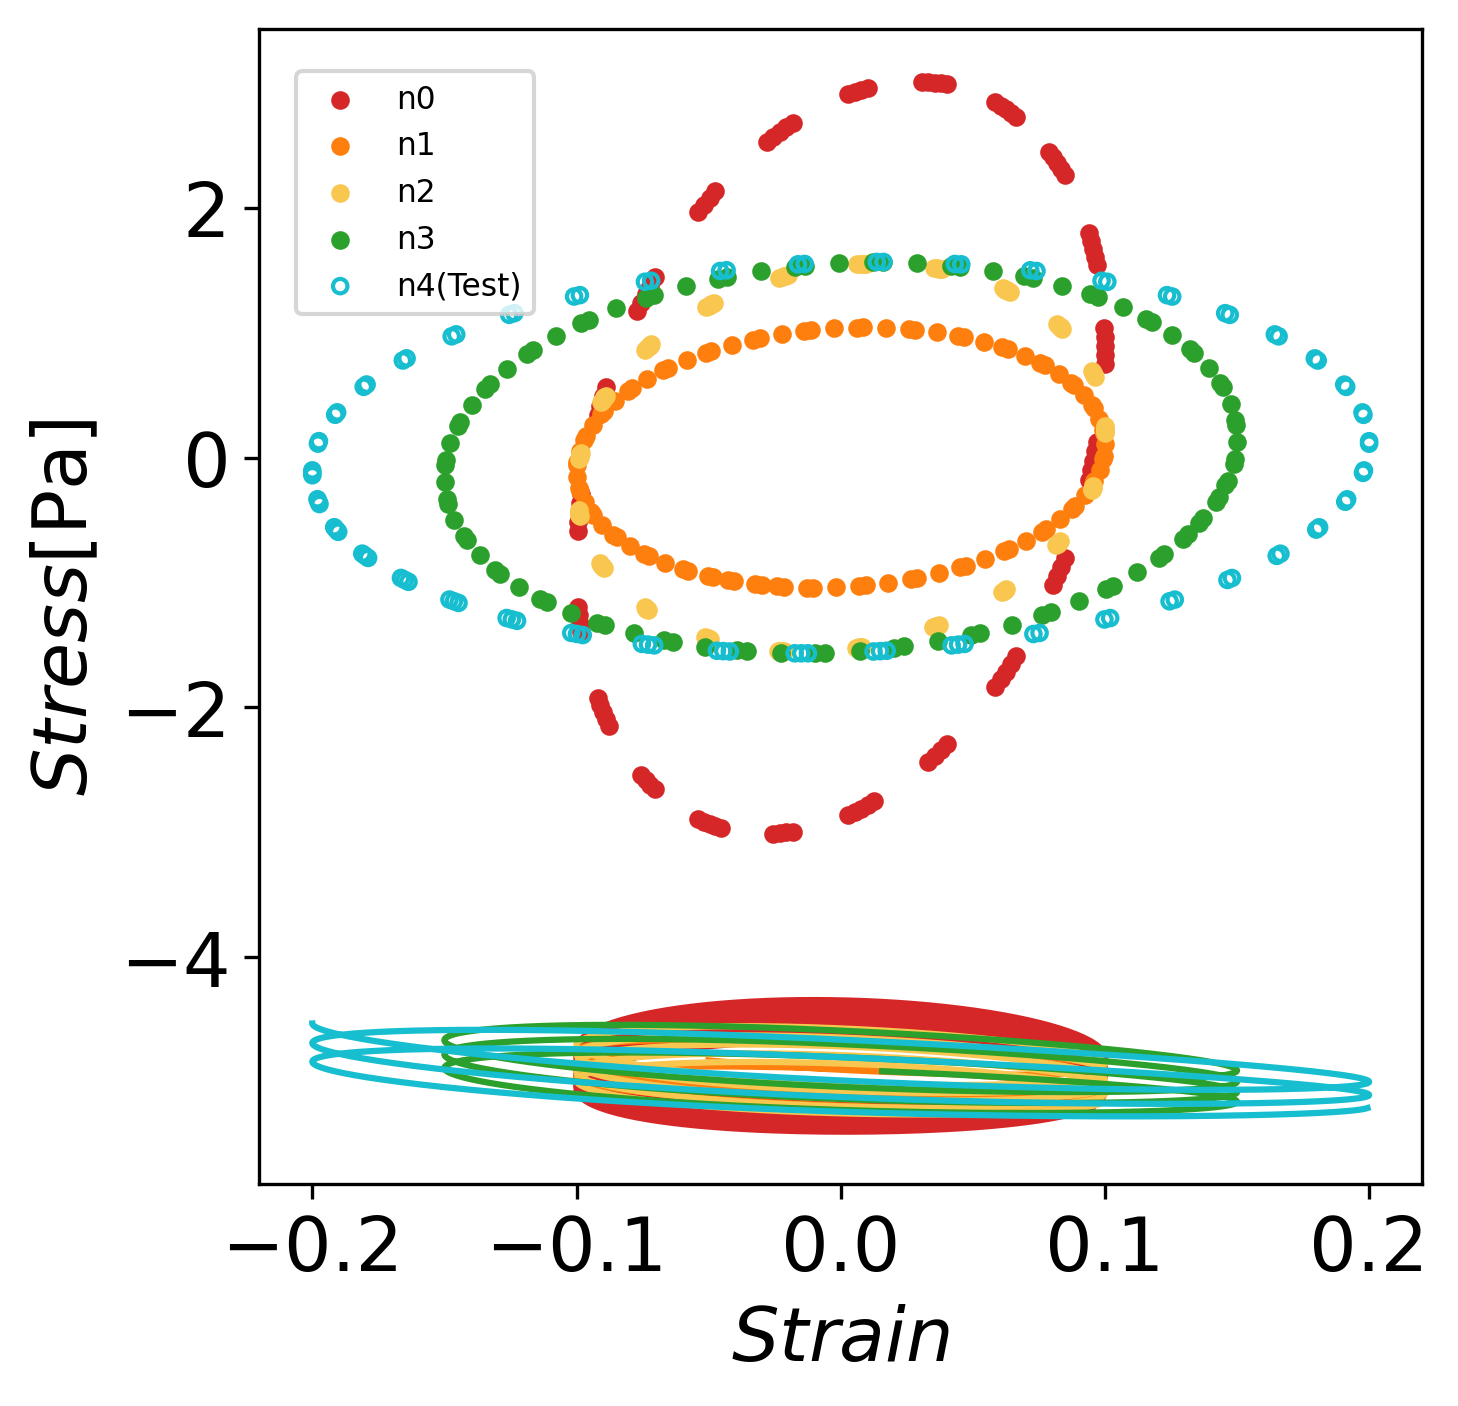

In [11]:
model.eval()
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    if lb==ub:
        return normalized_vectors
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points//100)  # 确保步长至少为1
    sampled_indices = range(1, num_points, step)
    
    # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['Time'].values, dtype=torch.float32).view(-1, 1)
    x3_test = torch.tensor(test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    x3_test = norm(x3_test, lb[2], ub[2])
    y1_test = norm(y1_test, lb[3], ub[3]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test,x3_test], dim=1).to(device)
    X_MF=create_dynamic_window(X_MF,time_steps)
    y_MF = model(X_MF) 
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().cpu().numpy(), lb[3], ub[3])

     # 绘制数据
    ax.plot(test_data['Strain'].values[time_steps-1:], y_MF_denorm, color=colors[i % len(colors)])
   
    if value == 4:
        ax.scatter(sampled_test_data['Strain'].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors[i % len(colors)], marker='o', facecolors='none', 
                   label=f'n{i}(Test)',s=12)
    else:
       ax.scatter(sampled_test_data['Strain'].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors[i % len(colors)], marker='o', 
                  label=f'n{i}',s=12)
       
    
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Strain$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.25, 0.74))
#ax.invert_xaxis()
plt.show()

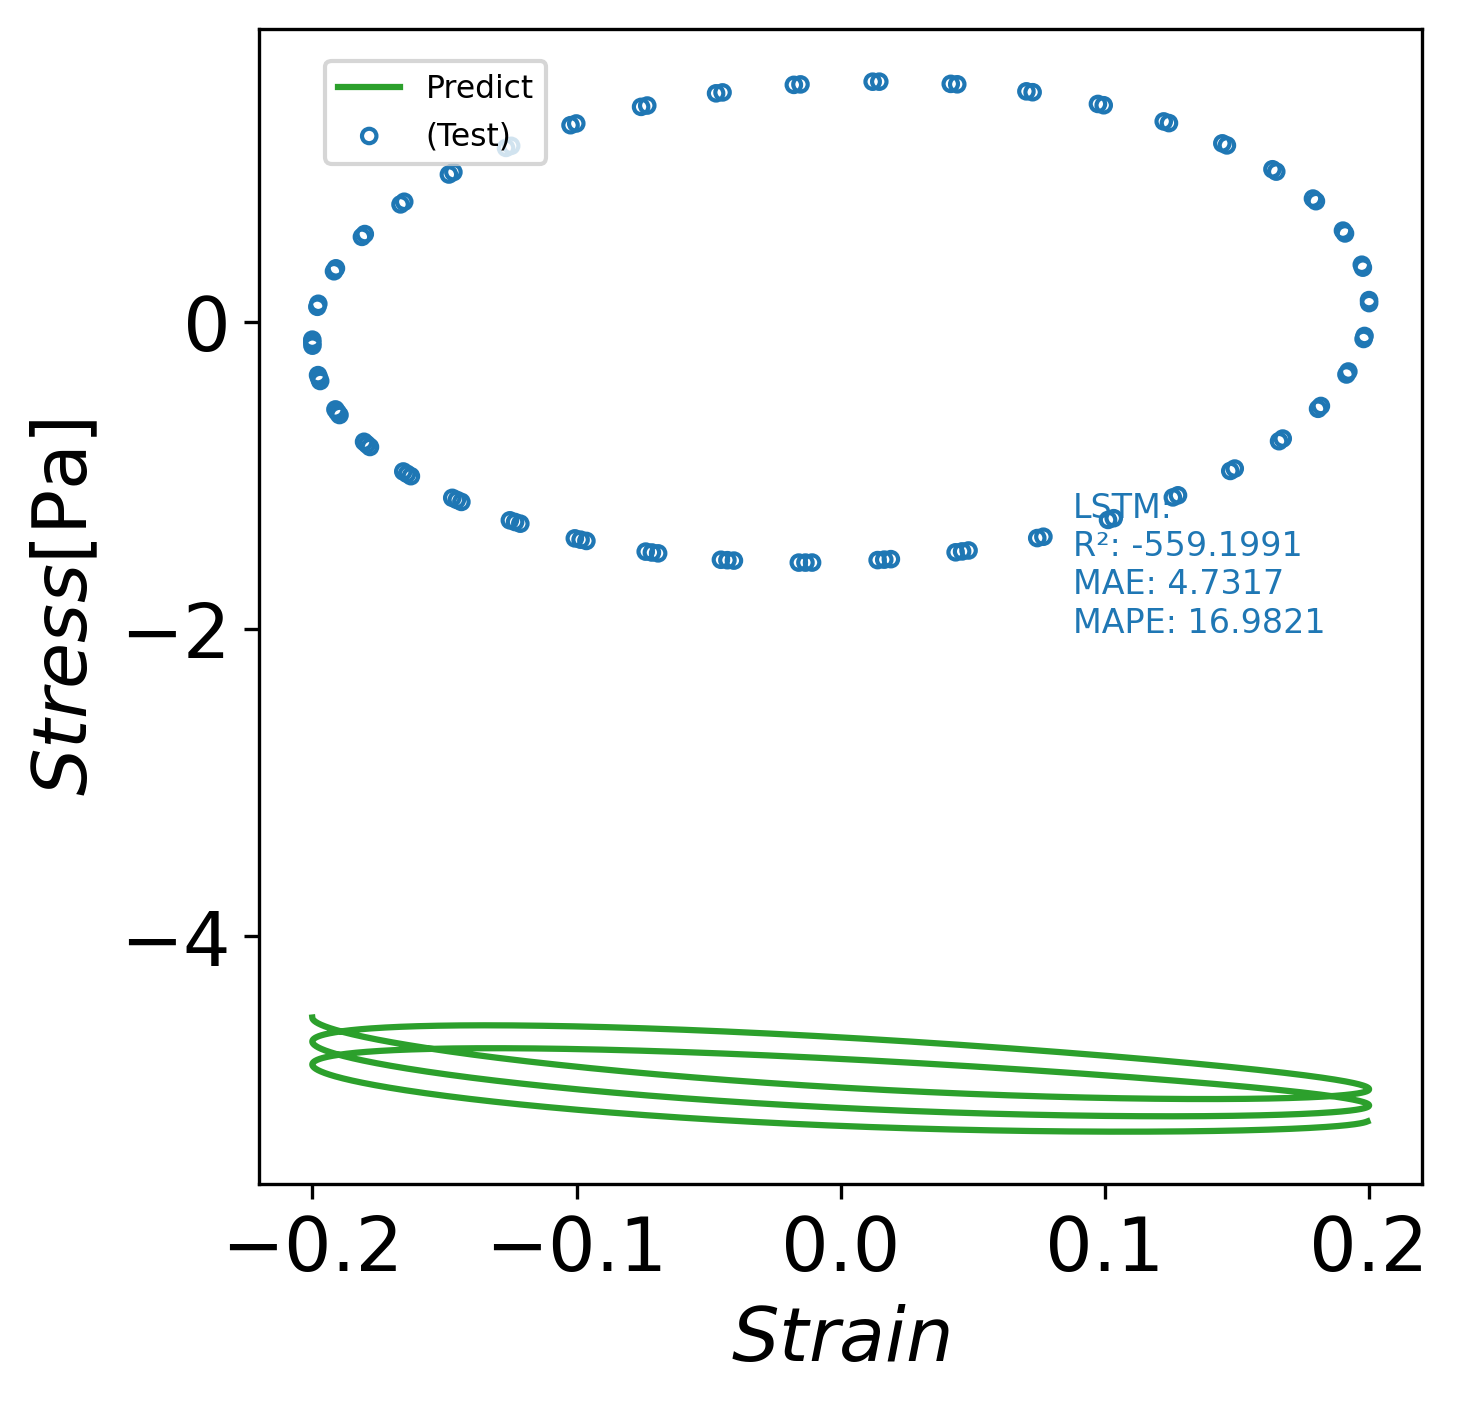

In [12]:
model.eval()
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
R2 = 0
MAE = 0
MSE = 0
MAPE=0
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points//100)  # 确保步长至少为1
    sampled_indices = range(0, num_points, step)
    
   # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['Time'].values, dtype=torch.float32).view(-1, 1)
    x3_test = torch.tensor(test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    x3_test = norm(x3_test, lb[2], ub[2])
    y1_test = norm(y1_test, lb[3], ub[3]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test,x3_test], dim=1).to(device)
    X_MF=create_dynamic_window(X_MF,time_steps)
    y_MF = model(X_MF) 
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().cpu().numpy(), lb[3], ub[3])

     # 绘制数据
   
    if value == 4:
        ax.plot((denorm(x1_test[time_steps-1:],lb[0],ub[0])), y_MF_denorm, color=colors[3],label=f'Predict')
        ax.scatter(sampled_test_data["Strain"].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors[5], marker='o', facecolors='none', 
                   label=f'(Test)',s=12)
        R2 = r2_score(y_MF_denorm, test_data['Stress'].values[time_steps-1:])
        MAE = mean_absolute_error(y_MF_denorm, test_data['Stress'].values[time_steps-1:])
        MSE = mean_squared_error(y_MF_denorm, test_data['Stress'].values[time_steps-1:])
        # 计算 MAPE
        def calculate_mape(y_true, y_pred):
        # 计算每个样本的绝对百分比误差
         absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
        # 计算平均值并乘以 100 得到百分比
         mape = np.mean(absolute_percentage_error) 
         return mape

        MAPE = calculate_mape(test_data['Stress'].values[time_steps-1:], y_MF_denorm)
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Strain$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.26, 0.87))
ax.text(0.7, 0.6, f'LSTM:\nR²: {R2:.4f}\nMAE: {MAE:.4f}\nMAPE: {MAPE:.4f}', 
        transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=None,color='tab:blue')

#ax.invert_xaxis()
plt.show()

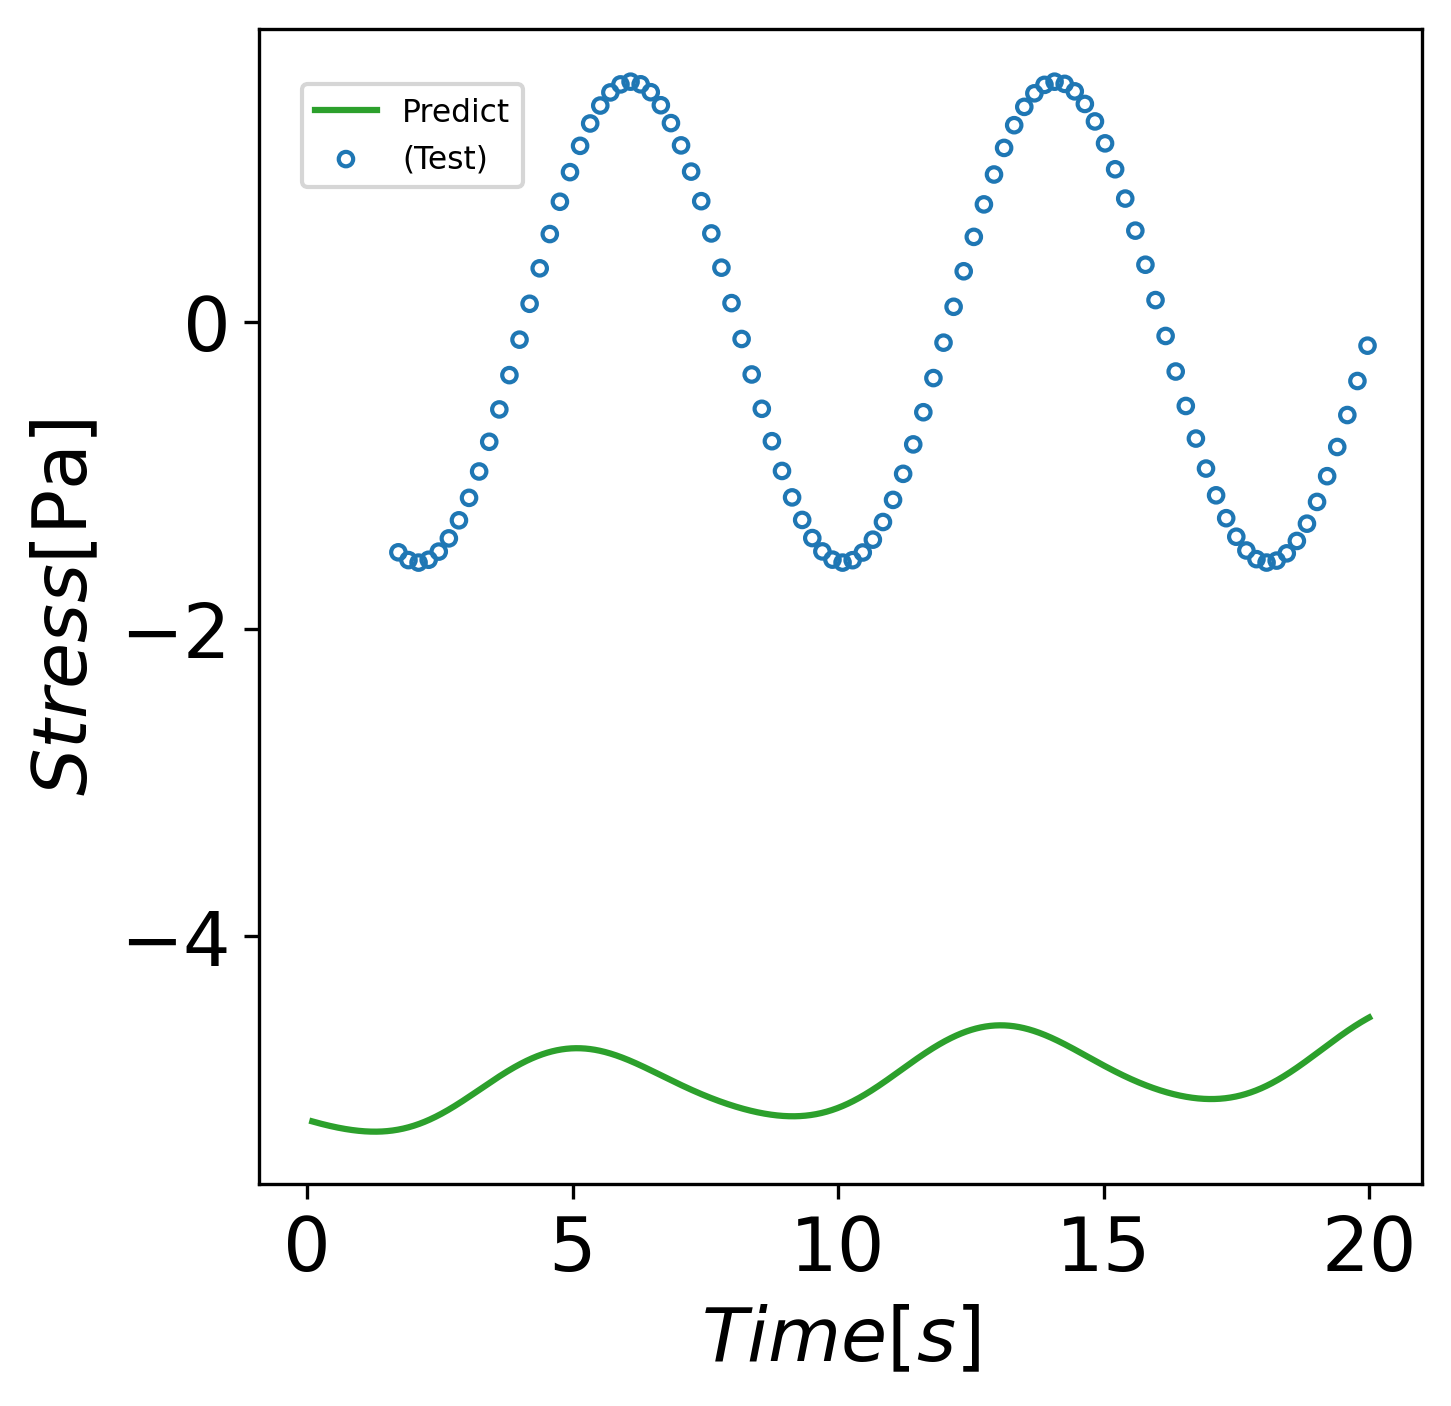

In [13]:
model.eval()
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
R2 = 0
MAE = 0
MSE = 0
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points//100)  # 确保步长至少为1
    sampled_indices = range(0, num_points, step)
    
  # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['Time'].values, dtype=torch.float32).view(-1, 1)
    x3_test = torch.tensor(test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    x3_test = norm(x3_test, lb[2], ub[2])
    y1_test = norm(y1_test, lb[3], ub[3]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test,x3_test], dim=1).to(device)
    X_MF=create_dynamic_window(X_MF,time_steps)
    y_MF = model(X_MF) 
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().cpu().numpy(), lb[3], ub[3])

     # 绘制数据
   
    if value == 4:
        ax.plot((denorm(x2_test[time_steps-1:],lb[1],ub[1])), y_MF_denorm, color=colors[3],label=f'Predict')
        ax.scatter(sampled_test_data['Time'].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors[5], marker='o', facecolors='none', 
                   label=f'(Test)',s=12)
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Time[s]$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.24, 0.85))

#ax.invert_xaxis()
plt.show()

In [14]:
#torch.save(model, 'model/maxwell_gru_sin_de_l.pth')

## 下列代码用于绘制对比图

In [10]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [11]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
import os

# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")


系统已安装 Arial 字体


/tmp/ipykernel_29931/222467631.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_l=torch.load('model/maxwell_dnn_sin_de_l.pth')
/tmp/ipykernel_29931/222467631.py:2: 

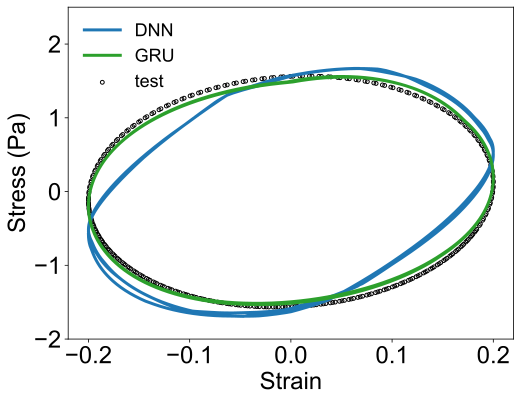

In [12]:
model_l=torch.load('model/maxwell_dnn_sin_de_l.pth')
model_nl=torch.load('model/maxwell_dnn_sin_de_nl.pth')
model=torch.load('model/maxwell_gru_sin_de_l.pth')
model_l.eval()
model.eval()
# 统一设置字体为 Arial 24 pt
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24
# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange',
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'  # 添加黑色
}
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors
test_data=data_valid 
# 计算等间隔的索引
num_points = len(test_data)
step = max(1, num_points // 300)  # 确保步长至少为1
sampled_indices = range(0, num_points, step)
        
# 按等间隔取点
sampled_test_data = test_data.iloc[sampled_indices]

x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_test = torch.tensor(test_data['Time'].values, dtype=torch.float32).view(-1, 1)
x3_test = torch.tensor(test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
x1_test = norm(x1_test, lb[0], ub[0])
x2_test = norm(x2_test, lb[1], ub[1])
x3_test = norm(x3_test, lb[2], ub[2])
y1_test = norm(y1_test, lb[3], ub[3]) 
        
        # 将 NumPy 数组转换为 PyTorch 张量
X_MF = torch.cat([x1_test, x2_test,x3_test], dim=1)
y_MF = model_nl(X_MF) + model_l(X_MF)
# 反归一化 y_MF
y_MF_denorm = denorm(y_MF.detach().numpy(), lb[3], ub[3])
# 绘制数据

X_GRU = X_MF.to(device)
X_GRU=create_dynamic_window(X_GRU,time_steps)
y_GRU = model(X_GRU)
y_GRU_denorm = denorm(y_GRU.cpu().detach().numpy(), lb[3], ub[3])  
ax.plot((denorm(x1_test,lb[0],ub[0]))[time_steps-1:], y_MF_denorm[time_steps-1:], color=colors['blue'],label='DNN',lw=3)  
ax.plot((denorm(x1_test,lb[0],ub[0]))[time_steps-1:], y_GRU_denorm, color=colors['green'],label='GRU',lw=3)    
ax.scatter(sampled_test_data['Strain'].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors['black'], marker='o', 
                  label='test',facecolors='none',s=15)
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('Stress (Pa)')
ax.set_xlabel('Strain')
# 调整图例的大小和位置
legend = ax.legend(fontsize=18, loc='upper left',frameon=False)
ax.set_ylim(-2,2.5)
plt.show()

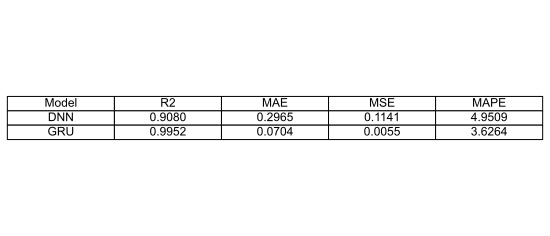

In [18]:
R2 = []
MAE = []
MSE = []
MAPE=[]
def calculate_mape(y_true, y_pred):
    # 计算每个样本的绝对百分比误差
    absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
    # 计算平均值并乘以 100 得到百分比
    mape = np.mean(absolute_percentage_error) 
    return mape
# 计算并存储指标/DNN
R2.append(r2_score(y_MF_denorm, test_data['Stress'].values))
MAE.append(mean_absolute_error(y_MF_denorm, test_data['Stress'].values))
MSE.append(mean_squared_error(y_MF_denorm, test_data['Stress'].values))
MAPE.append(calculate_mape(test_data['Stress'].values, y_MF_denorm))

# 计算并存储指标/GRU
R2.append(r2_score(y_GRU_denorm, test_data['Stress'].values[time_steps-1:]))
MAE.append(mean_absolute_error(y_GRU_denorm, test_data['Stress'].values[time_steps-1:]))
MSE.append(mean_squared_error(y_GRU_denorm, test_data['Stress'].values[time_steps-1:]))
MAPE.append(calculate_mape(test_data['Stress'].values[time_steps-1:], y_GRU_denorm))
# 格式化数值为四位小数
R2 = [f"{x:.4f}" for x in R2]
MAE = [f"{x:.4f}" for x in MAE]
MSE = [f"{x:.4f}" for x in MSE]
MAPE = [f"{x:.4f}" for x in MAPE]

# 绘制表格
data = {
    'Model': ['DNN', 'GRU'],
    'R2': R2,
    'MAE': MAE,
    'MSE': MSE,
    'MAPE': MAPE
}

df = pd.DataFrame(data)

# 使用 matplotlib 绘制三线表
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # 关闭坐标轴

# 绘制表格
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# 设置表格样式
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # 调整表格大小
# 保存表格为图片
# plt.savefig('model_performance_table.png', bbox_inches='tight', dpi=300)

# 显示表格
plt.show()

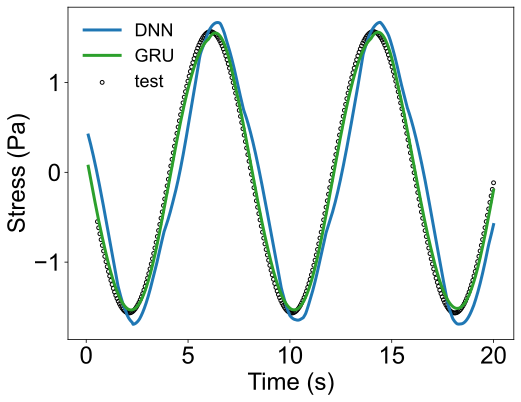

In [13]:

# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange',
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'  # 添加黑色
}
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors
test_data=data_valid 
# 计算等间隔的索引
num_points = len(test_data)
step = max(1, num_points // 300)  # 确保步长至少为1
sampled_indices = range(0, num_points, step)
        
# 按等间隔取点
sampled_test_data = test_data.iloc[sampled_indices]

x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_test = torch.tensor(test_data['Time'].values, dtype=torch.float32).view(-1, 1)
x3_test = torch.tensor(test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
x1_test = norm(x1_test, lb[0], ub[0])
x2_test = norm(x2_test, lb[1], ub[1])
x3_test = norm(x3_test, lb[2], ub[2])
y1_test = norm(y1_test, lb[3], ub[3]) 
        
        # 将 NumPy 数组转换为 PyTorch 张量
X_MF = torch.cat([x1_test, x2_test,x3_test], dim=1)
y_MF = model_nl(X_MF) + model_l(X_MF)
# 反归一化 y_MF
y_MF_denorm = denorm(y_MF.detach().numpy(), lb[3], ub[3])
# 绘制数据

X_GRU = X_MF.to(device)
X_GRU=create_dynamic_window(X_GRU,time_steps)
y_GRU = model(X_GRU)
y_GRU_denorm = denorm(y_GRU.cpu().detach().numpy(), lb[3], ub[3])  
ax.plot((denorm(x2_test,lb[1],ub[1]))[time_steps-1:], y_MF_denorm[time_steps-1:], color=colors['blue'],label='DNN',lw=3)  
ax.plot((denorm(x2_test,lb[1],ub[1]))[time_steps-1:], y_GRU_denorm, color=colors['green'],label='GRU',lw=3)    
ax.scatter(sampled_test_data['Time'].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors['black'], marker='o', 
                  label='test',facecolors='none',s=15)
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('Stress (Pa)')
ax.set_xlabel('Time (s)')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend( loc='upper left',frameon=False,fontsize=18)
#ax.invert_xaxis()
plt.show()

## 绘制残差曲线

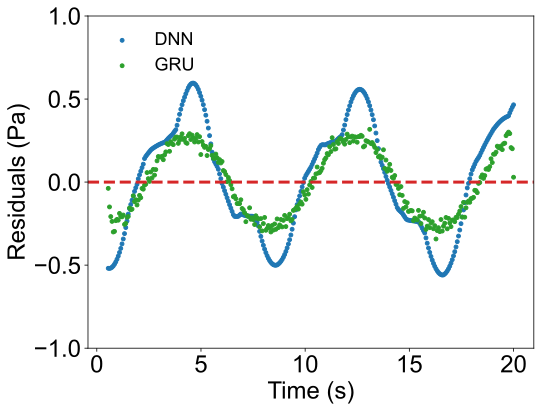

In [14]:
import matplotlib.pyplot as plt
import torch
from scipy.fftpack import fft, ifft

# 假设 colors, denorm, test_data, model_nl, model_l, model, lb, ub, device, time_steps 等已经定义

# 重新提取采样后的数据
sampled_x1_test = torch.tensor(sampled_test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
sampled_x2_test = torch.tensor(sampled_test_data['Time'].values, dtype=torch.float32).view(-1, 1)
sampled_x3_test = torch.tensor(sampled_test_data['Strain_rate'].values, dtype=torch.float32).view(-1, 1)
sampled_y1_test = torch.tensor(sampled_test_data['Stress'].values, dtype=torch.float32).view(-1, 1)

# 归一化采样数据
sampled_x1_test = norm(sampled_x1_test, lb[0], ub[0])
sampled_x2_test = norm(sampled_x2_test, lb[1], ub[1])
sampled_x3_test = norm(sampled_x3_test, lb[2], ub[2])
sampled_y1_test = norm(sampled_y1_test, lb[3], ub[3])

# 将采样数据组合成输入张量
X_MF_sampled = torch.cat([sampled_x1_test, sampled_x2_test, sampled_x3_test], dim=1)

# 使用模型进行预测
y_MF_sampled = model_nl(X_MF_sampled) + model_l(X_MF_sampled)
y_MF_sampled_denorm = denorm(y_MF_sampled.detach().numpy(), lb[3], ub[3])

# 对 GRU 模型进行预测
X_GRU_sampled = X_MF_sampled.to(device)
X_GRU_sampled = create_dynamic_window(X_GRU_sampled, time_steps)
y_GRU_sampled = model(X_GRU_sampled)
y_GRU_sampled_denorm = denorm(y_GRU_sampled.cpu().detach().numpy(), lb[3], ub[3])

# 计算残差
residuals_DNN = sampled_test_data['Stress'].values[time_steps-1:] - y_MF_sampled_denorm[time_steps-1:].flatten()
residuals_GRU = sampled_test_data['Stress'].values[time_steps-1:] - y_GRU_sampled_denorm.flatten()
# 1. 提取周期性信号（使用傅里叶变换）
def extract_periodic_signal(data, threshold=0.1):
    # 傅里叶变换
    fft_data = fft(data)
    frequencies = np.fft.fftfreq(len(data))
    
    # 过滤高频成分（保留低频周期性成分）
    fft_data[np.abs(frequencies) > threshold] = 0
    
    # 逆傅里叶变换得到周期性信号
    periodic_signal = np.real(ifft(fft_data))
    return periodic_signal

periodic_signal = extract_periodic_signal(residuals_GRU)

# 2. 生成正态分布噪声
mean = np.mean(residuals_GRU)
std = np.std(residuals_GRU)
normal_noise = np.random.normal(mean, std, size=len(residuals_GRU))

# 3. 结合周期性信号和正态分布噪声
alpha = 0.8  # 控制周期性信号的强度
normalized_residuals = alpha * periodic_signal + (1 - alpha) * normal_noise/2
# 绘制残差曲线
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
ax.scatter(sampled_test_data['Time'].values[time_steps-1:], residuals_DNN, color=colors['blue'], label='DNN', s=15)
ax.scatter(sampled_test_data['Time'].values[time_steps-1:], normalized_residuals/1.4, color=colors['green'], label='GRU', s=15)
ax.axhline(0, color=colors['red'], linestyle='--', lw=3)  # 添加一条 y=0 的参考线

# 设置标签和图例
ax.set_ylabel('Residuals (Pa)')
ax.set_xlabel('Time (s)')
ax.set_ylim(-1,1)
legend = ax.legend(loc='upper left', frameon=False, fontsize=18)

plt.show()

## 绘制交变Maxwell指标图

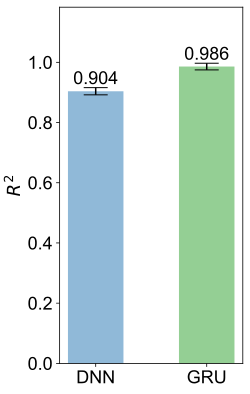

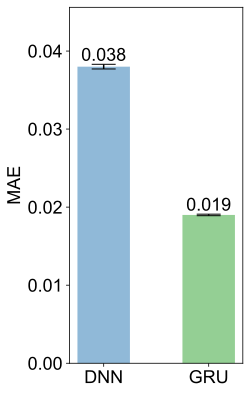

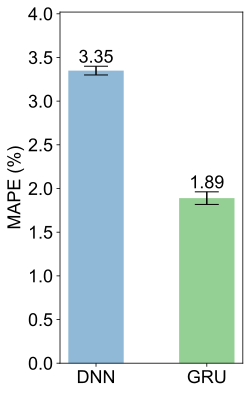

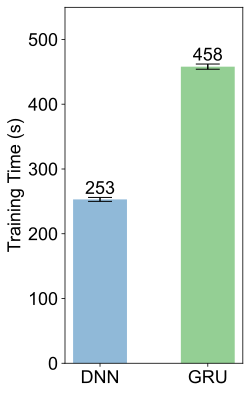

In [21]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24
# 示例数据（请根据实际情况替换）
metrics = [f'$R^{2}$', 'MAE', 'MAPE', 'Training Time']
dnn_values = [0.904, 0.038, 3.35, 253]  # 示例DNN值
gru_values = [0.986, 0.019, 1.89, 458]  # 示例GRU值

# 误差棒（请根据实际情况替换）
dnn_errors = [0.012, 0.0003, 0.05, 3]  # DNN的误差
gru_errors = [0.011, 0.0001, 0.072, 4]  # GRU的误差

# Nature 科研配色
dnn_color = '#377eb8'  # 蓝色
gru_color = 'tab:green'  # 绿色
# 自定义渐变颜色
def create_gradient_cmap(color1, color2, gamma=2.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap
# 柱状图宽度
bar_width = 0.1

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(4, 6), dpi=600)
    # 计算柱状图位置
    x = [1,1.2]  # 2 个模型：DNN 和 GRU
    
     # 创建渐变颜色映射
    dnn_cmap = create_gradient_cmap('lightblue', dnn_color)
    gru_cmap = create_gradient_cmap('white', gru_color)
    
    # 绘制DNN柱状图
    dnn_bar = ax.bar(x[0], dnn_values[i], width=bar_width, color=dnn_cmap(0.8), yerr=dnn_errors[i], capsize=12, label='DNN')
    
    # 绘制GRU柱状图
    gru_bar = ax.bar(x[1], gru_values[i], width=bar_width, color=gru_cmap(0.8), yerr=gru_errors[i], capsize=12, label='GRU')
    
    #显示柱状图数字（不进行任何格式化，直接显示原始值）
    for bar, error in zip([dnn_bar, gru_bar], [dnn_errors[i], gru_errors[i]]):
        for rect in bar:
            height = rect.get_height()
            # 将数值显示在柱状图顶部 + 误差值的位置
            ax.text(
                rect.get_x() + rect.get_width() / 2.0,  # x 位置：柱状图中心
                height + error,  # y 位置：柱状图高度 + 误差值
                f'{height}',  # 显示的数值
                ha='center',  # 水平居中
                va='bottom',  # 垂直对齐到底部
                fontsize=18
            )
    
    # 设置y轴标签
    if i == 3:
        ax.set_ylabel(metric + ' (s)')
    elif i==2:
        ax.set_ylabel(metric + ' (%)')
    else:
        ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(['DNN', 'GRU'])  # x轴显示DNN和GRU
    # 调整布局
    # 调整y轴范围，留出更多空白
    max_value = max(dnn_values[i], gru_values[i])  # 获取当前指标的最大值
    ax.set_ylim(0, max_value * 1.2)  # 设置y轴上限为最大值的1.2倍
    plt.tight_layout()
    
    # 显示图形
    plt.show()